#Load Data from Kaggle

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d validmodel/indo-fashion-dataset

100% 2.69G/2.69G [00:31<00:00, 81.0MB/s]
100% 2.69G/2.69G [00:31<00:00, 92.1MB/s]


In [ ]:
!unzip indo-fashion-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/val/3250.jpeg    
  inflating: images/val/3251.jpeg    
  inflating: images/val/3252.jpeg    
  inflating: images/val/3253.jpeg    
  inflating: images/val/3254.jpeg    
  inflating: images/val/3255.jpeg    
  inflating: images/val/3256.jpeg    
  inflating: images/val/3257.jpeg    
  inflating: images/val/3258.jpeg    
  inflating: images/val/3259.jpeg    
  inflating: images/val/326.jpeg     
  inflating: images/val/3260.jpeg    
  inflating: images/val/3261.jpeg    
  inflating: images/val/3262.jpeg    
  inflating: images/val/3263.jpeg    
  inflating: images/val/3264.jpeg    
  inflating: images/val/3265.jpeg    
  inflating: images/val/3266.jpeg    
  inflating: images/val/3267.jpeg    
  inflating: images/val/3268.jpeg    
  inflating: images/val/3269.jpeg    
  inflating: images/val/327.jpeg     
  inflating: images/val/3270.jpeg    
  inflating: images/val/3271.jpeg    
  inflating: images/val/3272.jpeg    

#Dataset Pruning

In [ ]:
import json

classLabels = set()

with open('/content/val_data.json', 'r') as file:
  for line in file:
    sample = json.loads(line)
    classLabels.add(sample.get('class_label'))

In [ ]:
classLabels

{'blouse',
 'dhoti_pants',
 'dupattas',
 'gowns',
 'kurta_men',
 'leggings_and_salwars',
 'lehenga',
 'mojaris_men',
 'mojaris_women',
 'nehru_jackets',
 'palazzos',
 'petticoats',
 'saree',
 'sherwanis',
 'women_kurta'}

In [ ]:
import json

selected_samples=[]
counts={'gowns':0,
 'kurta_men':0,
 'lehenga':0,
 'nehru_jackets':0,
 'palazzos':0,
 'saree':0,
 'sherwanis':0,
 'women_kurta':0}
with open('/content/train_data.json', 'r') as file:
  for line in file:
    sample = json.loads(line)
    #print(sample['class_label'])
    #break
    if(sample['class_label'] not in ['blouse','leggings_and_salwars','mojaris_men','mojaris_women','dhoti_pants','petticoats', 'dupattas']):
      label = sample.get('class_label')
      if(counts[label]<6000):
        selected_samples.append(sample)
        counts[label]=counts[label]+1

In [ ]:
n_samples=len(selected_samples)
print(f"No. of samples after pruning - {n_samples}")
print("Distribution of samples: \n")
print(counts)

No. of samples after pruning - 41331
Distribution of samples: 

{'gowns': 5211, 'kurta_men': 6000, 'lehenga': 5753, 'nehru_jackets': 6000, 'palazzos': 3375, 'saree': 6000, 'sherwanis': 2992, 'women_kurta': 6000}


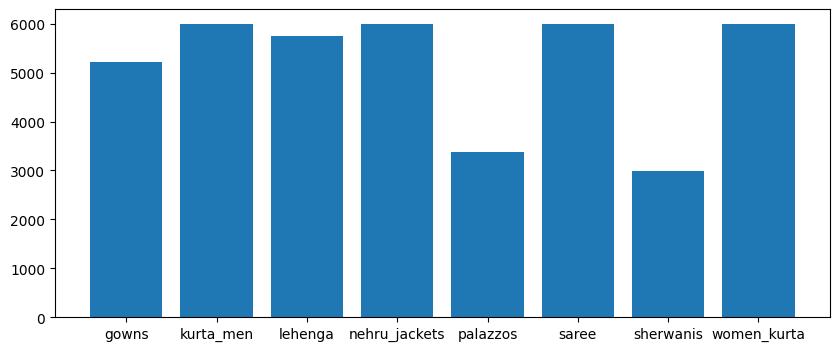

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,4))
plt.bar(counts.keys(), counts.values(), alpha=1)
plt.show()

In [ ]:
selected_samples[0]

{'image_url': 'https://m.media-amazon.com/images/I/81XKaSKvlyL._AC_UL320_.jpg',
 'image_path': 'images/train/0.jpeg',
 'brand': 'Womanista',
 'product_title': "Women's Georgette Saree with Blouse Piece (TKIM811_Black_Free Size)",
 'class_label': 'saree'}

In [ ]:
import pandas as pd
train_df = pd.DataFrame(selected_samples)

In [ ]:
train_df.head()

,image_url,image_path,brand,product_title,class_label,color
0,https://m.media-amazon.com/images/I/81XKaSKvly...,images/train/0.jpeg,Womanista,Women's Georgette Saree with Blouse Piece (TKI...,saree,NaN
1,https://m.media-amazon.com/images/I/91dDMDg+QT...,images/train/1.jpeg,Yashika,Women Linen Printed Sarees Free Size (BEE),saree,NaN
2,https://m.media-amazon.com/images/I/71TJ9p46PV...,images/train/2.jpeg,Womanista,Organza Floral Print Saree with Blouse Piece(W...,saree,NaN
3,https://m.media-amazon.com/images/I/81Y+je7CEg...,images/train/3.jpeg,PERFECTBLUE,Women's Digital Cotton Linen Blend Saree with ...,saree,NaN
4,https://m.media-amazon.com/images/I/61B8o9Ulqp...,images/train/4.jpeg,VAIVIDHYAM,Designer Sarees Women's Banarasi Cotton Silk S...,saree,NaN


In [ ]:
train_df.drop(columns=['brand', 'product_title', 'color'], inplace=True)
train_df.head()

,image_url,image_path,class_label
0,https://m.media-amazon.com/images/I/81XKaSKvly...,images/train/0.jpeg,saree
1,https://m.media-amazon.com/images/I/91dDMDg+QT...,images/train/1.jpeg,saree
2,https://m.media-amazon.com/images/I/71TJ9p46PV...,images/train/2.jpeg,saree
3,https://m.media-amazon.com/images/I/81Y+je7CEg...,images/train/3.jpeg,saree
4,https://m.media-amazon.com/images/I/61B8o9Ulqp...,images/train/4.jpeg,saree


In [ ]:
train_df.to_csv("pruned_train_data.csv", index=False)

In [ ]:
test_selected_samples=[]
test_counts={'gowns':0,
 'kurta_men':0,
 'lehenga':0,
 'nehru_jackets':0,
 'palazzos':0,
 'saree':0,
 'sherwanis':0,
 'women_kurta':0}

with open('/content/test_data.json', 'r') as file:
  for line in file:
    sample = json.loads(line)
    if(sample['class_label'] not in ['blouse','leggings_and_salwars','mojaris_men','mojaris_women','dhoti_pants','petticoats', 'dupattas']):
      label = sample.get('class_label')
      test_selected_samples.append(sample)
      test_counts[label]=test_counts[label]+1

In [ ]:
n_test_samples=len(test_selected_samples)
print(f"No. of test samples after pruning - {n_test_samples}")
print("Distribution of test samples: \n")
print(test_counts)

No. of test samples after pruning - 4000
Distribution of test samples: 

{'gowns': 500, 'kurta_men': 500, 'lehenga': 500, 'nehru_jackets': 500, 'palazzos': 500, 'saree': 500, 'sherwanis': 500, 'women_kurta': 500}


In [ ]:
test_df = pd.DataFrame(test_selected_samples)
test_df.drop(columns=['brand', 'product_title', 'color'], inplace=True)
test_df.head()

,image_url,image_path,class_label
0,https://m.media-amazon.com/images/I/71NZQ-aaAS...,images/test/0.jpeg,saree
1,https://m.media-amazon.com/images/I/81aQmbWsG7...,images/test/1.jpeg,saree
2,https://m.media-amazon.com/images/I/71YjGvzs9y...,images/test/2.jpeg,saree
3,https://m.media-amazon.com/images/I/81JYhYV5Xr...,images/test/3.jpeg,saree
4,https://m.media-amazon.com/images/I/91fXc5i5Dy...,images/test/4.jpeg,saree


In [ ]:
test_df.to_csv("pruned_test_data.csv",index=False)

In [ ]:
val_selected_samples=[]
val_counts={'gowns':0,
 'kurta_men':0,
 'lehenga':0,
 'nehru_jackets':0,
 'palazzos':0,
 'saree':0,
 'sherwanis':0,
 'women_kurta':0}

with open('/content/val_data.json', 'r') as file:
  for line in file:
    sample = json.loads(line)
    if(sample['class_label'] not in ['blouse','leggings_and_salwars','mojaris_men','mojaris_women','dhoti_pants','petticoats', 'dupattas']):
      label = sample.get('class_label')
      val_selected_samples.append(sample)
      val_counts[label]=val_counts[label]+1

In [ ]:
n_val_samples=len(val_selected_samples)
print(f"No. of valiadation samples after pruning - {n_val_samples}")
print("Distribution of validation samples: \n")
print(val_counts)

No. of valiadation samples after pruning - 4000
Distribution of validation samples: 

{'gowns': 500, 'kurta_men': 500, 'lehenga': 500, 'nehru_jackets': 500, 'palazzos': 500, 'saree': 500, 'sherwanis': 500, 'women_kurta': 500}


In [ ]:
val_df = pd.DataFrame(val_selected_samples)
val_df.drop(columns=['brand', 'product_title', 'color'], inplace=True)
val_df.head()

,image_url,image_path,class_label
0,https://m.media-amazon.com/images/I/81LOPbFPiQ...,images/val/0.jpeg,saree
1,https://m.media-amazon.com/images/I/81Q8Oktw4s...,images/val/1.jpeg,saree
2,https://m.media-amazon.com/images/I/613S1YGCmo...,images/val/2.jpeg,saree
3,https://m.media-amazon.com/images/I/819budhQl1...,images/val/3.jpeg,saree
4,https://m.media-amazon.com/images/I/61cAZ94ZQV...,images/val/4.jpeg,saree


In [ ]:
val_df.to_csv("pruned_val_data.csv",index=False)

#Preprocessing

In [ ]:
import pandas as pd
training_data = pd.read_csv('/content/pruned_train_data.csv')
training_data.head()

,image_url,image_path,class_label
0,https://m.media-amazon.com/images/I/81XKaSKvly...,images/train/0.jpeg,saree
1,https://m.media-amazon.com/images/I/91dDMDg+QT...,images/train/1.jpeg,saree
2,https://m.media-amazon.com/images/I/71TJ9p46PV...,images/train/2.jpeg,saree
3,https://m.media-amazon.com/images/I/81Y+je7CEg...,images/train/3.jpeg,saree
4,https://m.media-amazon.com/images/I/61B8o9Ulqp...,images/train/4.jpeg,saree


In [ ]:
from PIL import Image
image = Image.open(training_data['image_path'][0])

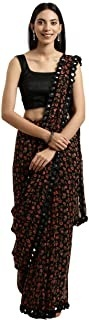

In [ ]:
image